# URL clustering based on similarity

- urls_df = full dataset
- urls_tdf = full dataset transformed
- urls_tsdf = sampled dataset transformed

## Imports & Helper functions

### Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

sns.set()

### Helper functions

In [2]:
from polyleven import levenshtein


def levenshtein_pdist(u, v):
    if isinstance(u, np.ndarray):
        u = u[0]
    if isinstance(v, np.ndarray):
        v = v[0]
    return levenshtein(u, v)


class SklearnStringTrick:
    """
    String clustering trick shown at:
        https://scikit-learn.org/0.16/faq.html#how-do-i-deal-with-string-data-or-trees-graphs

    Class structure allows for method reuse over distinct data

    """

    def __init__(self, dataset=[]):
        self.dataset = dataset

    def lev_dist_sklearn_urls(self, x, y):
        i, j = int(x[0]), int(y[0])  # extract indices
        return levenshtein(self.dataset[i], self.dataset[j])

In [3]:
string_trick = SklearnStringTrick()

## Preprocessing

In [4]:
urls_df = pd.read_csv(
    "datasets/kaggle_siddharta_malicious_benign.csv",
    delimiter=",",
    dtype={"url": "string"},
)

urls_df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


## Extract domain names from URLs

In [5]:
# Regex pattern to extract domain name
pattern = r"(?:.*?:\/\/)?(?P<www>[wW]{3}\.)?(?P<domain>[\w\.\-]+)[^\w]*"

# Execute regex over URLs
match = urls_df["url"].str.extract(pattern)

# Extract domain using named group
urls_df["domain"] = match["domain"]

# Indicate if www subdomain is present
urls_df["has_www"] = match["www"].isna()

urls_df.head()

,url,type,domain,has_www
0,br-icloud.com.br,phishing,br-icloud.com.br,True
1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com,True
2,bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org,True
3,http://www.garage-pirenne.be/index.php?option=...,defacement,garage-pirenne.be,False
4,http://adventure-nicaragua.net/index.php?optio...,defacement,adventure-nicaragua.net,True


In [6]:
# Create OneHotEncoded features from type

from sklearn.preprocessing import OneHotEncoder

ohenc = OneHotEncoder(sparse_output=False)
type_ohenc = pd.DataFrame(
    ohenc.fit_transform(urls_df["type"].values.reshape(-1, 1)),
    columns=ohenc.categories_[0],
).astype(bool)

# URLs_transformed df
urls_tdf = pd.concat([urls_df, type_ohenc], axis=1)

In [7]:
urls_tdf["malicious"] = ~urls_tdf["benign"]
urls_tdf.head()

,url,type,domain,has_www,benign,defacement,malware,phishing,malicious
0,br-icloud.com.br,phishing,br-icloud.com.br,True,False,False,False,True,True
1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com,True,True,False,False,False,False
2,bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org,True,True,False,False,False,False
3,http://www.garage-pirenne.be/index.php?option=...,defacement,garage-pirenne.be,False,False,True,False,False,True
4,http://adventure-nicaragua.net/index.php?optio...,defacement,adventure-nicaragua.net,True,False,True,False,False,True


## Data exploration

### Levenshtein distances

#### URL unchanged

In [8]:
# Create two sets of N_SAMPLES random samples
N_SAMPLES = 50000

urls_tsdf = pd.DataFrame()

urls_tsdf["sample1"] = urls_tdf.sample(n=N_SAMPLES, random_state=123).reset_index(
    drop=True
)["url"]
urls_tsdf["sample2"] = urls_tdf.sample(n=N_SAMPLES, random_state=545).reset_index(
    drop=True
)["url"]

In [9]:
# Calculate Levenshtein distance on each pair (N_SAMPLES distances)
urls_tsdf["levenshtein_distance"] = urls_tsdf.apply(
    lambda row: levenshtein(row.sample1, row.sample2), axis=1
)

Text(0.5, 1.0, "Distribution of levenshtein's distances over 50000 random samples")

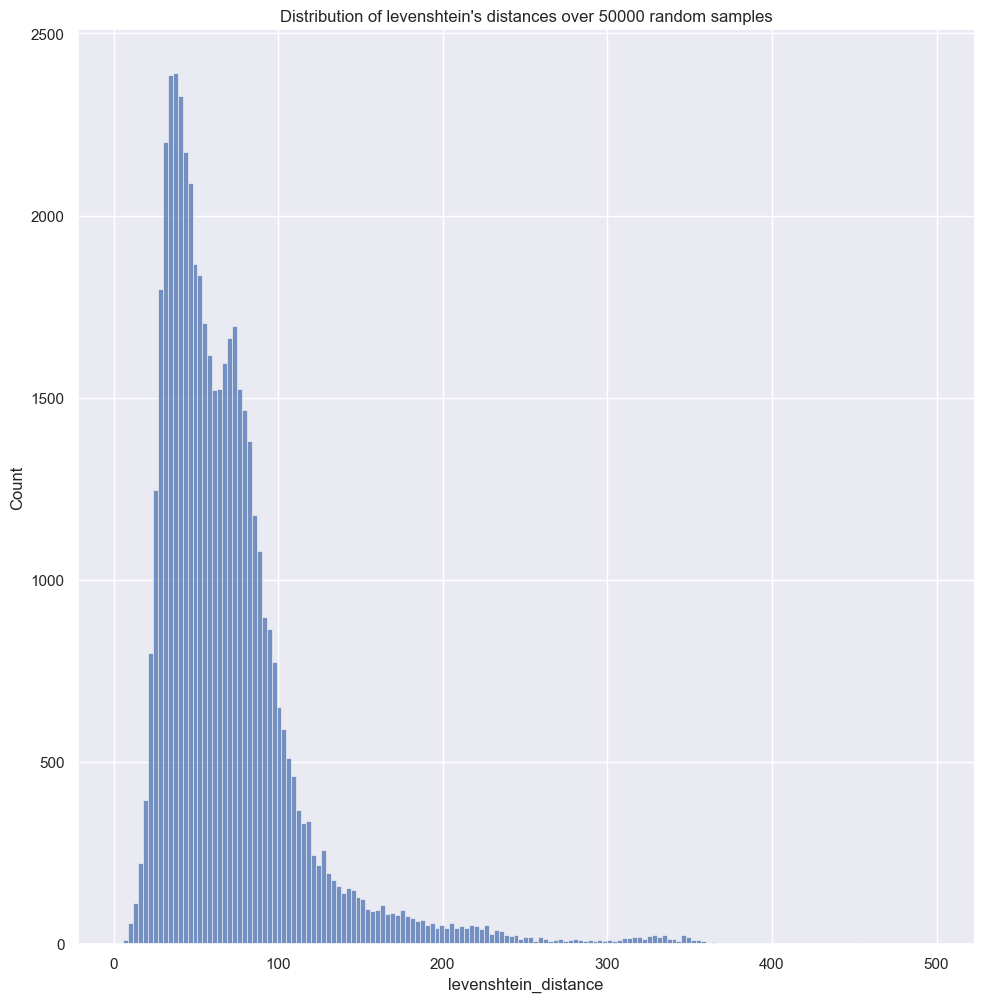

In [10]:
sns.displot(
    urls_tsdf[urls_tsdf["levenshtein_distance"] < 500],
    x="levenshtein_distance",
    binwidth=3,
    height=10,
)
plt.title(f"Distribution of levenshtein's distances over {N_SAMPLES} random samples")

## Experiments

### Unchanged URLs

Keep `urls_tdf` intact for this section to show what it should

#### DBSCAN

DBSCAN will not work. It needs $\mathcal{O}(n^2)$

#### Hierarchical clustering

In [11]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

In [12]:
# Create two sets of N_SAMPLES random samples
N_SAMPLES = 1000

urls_tsdf = urls_tdf.sample(n=N_SAMPLES, random_state=111).reset_index(drop=True)

In [13]:
# Calculate pairwise distances between URLs using levenshtein distance function
X = urls_tsdf["url"].values.reshape(-1, 1)
distances = pdist(X, metric=levenshtein_pdist)
distances_squareform = squareform(distances)

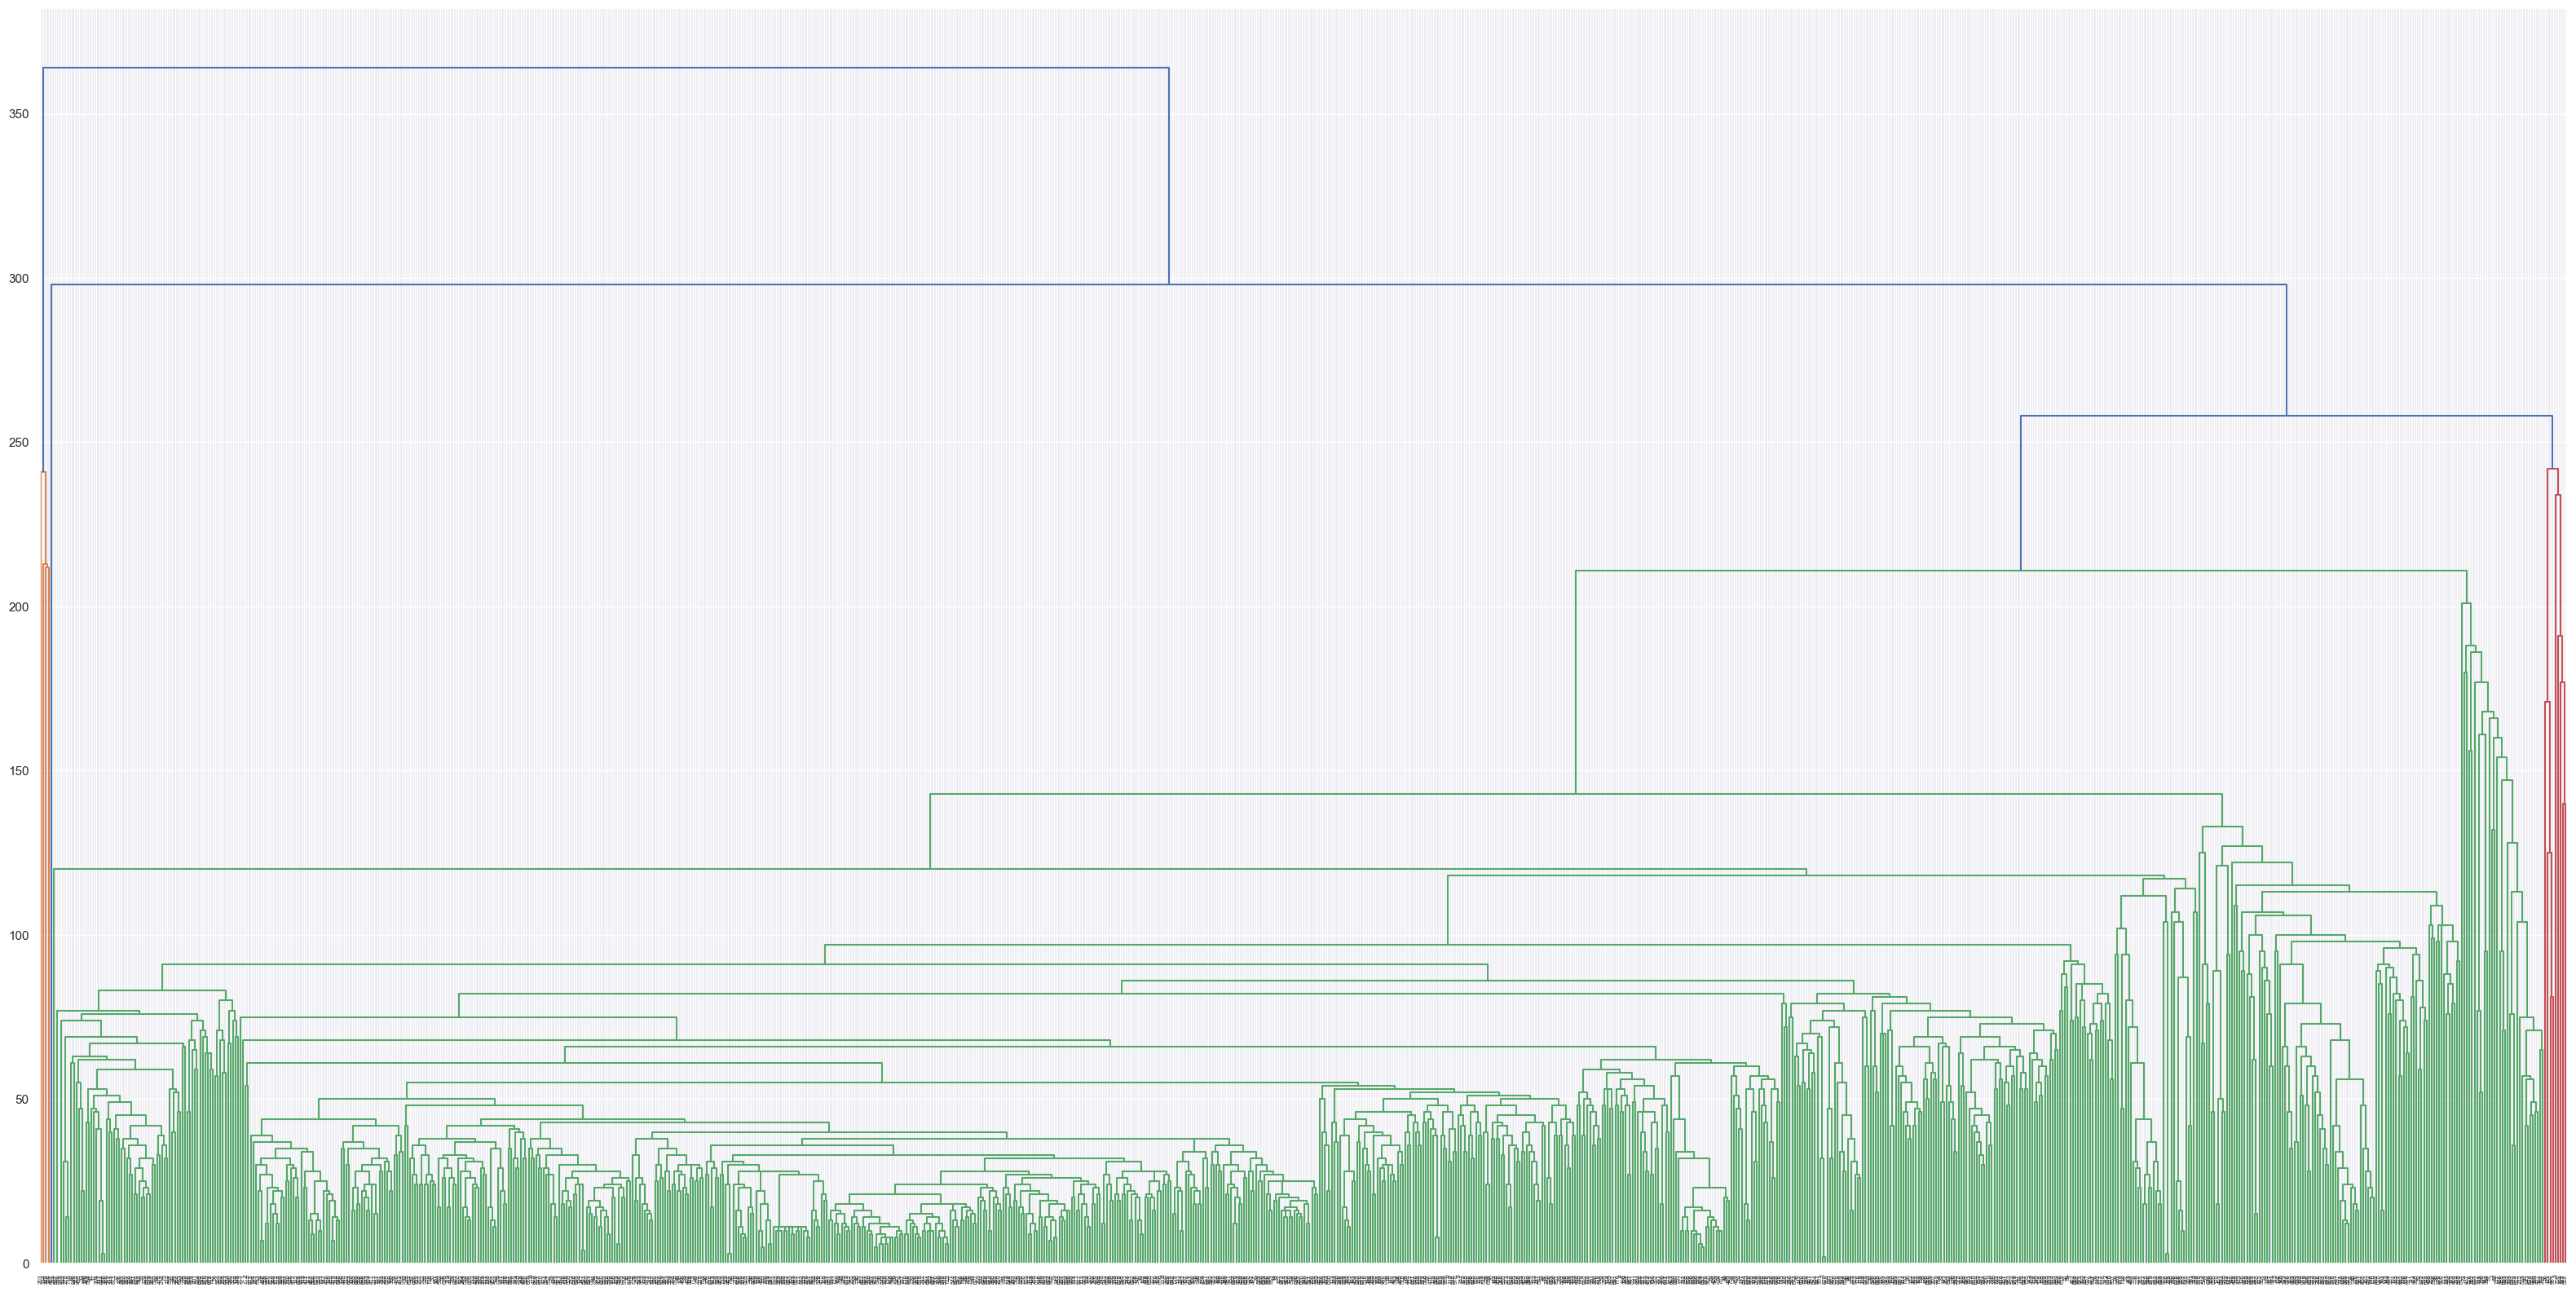

In [14]:
# Perform hierarchical clustering
Z = linkage(distances, "complete")

# Draw dendrogram for visual cutoff selection
fig, ax = plt.subplots(figsize=(40, 20))
dendrogram(Z, ax=ax)


fig1 = fig
plt.show()

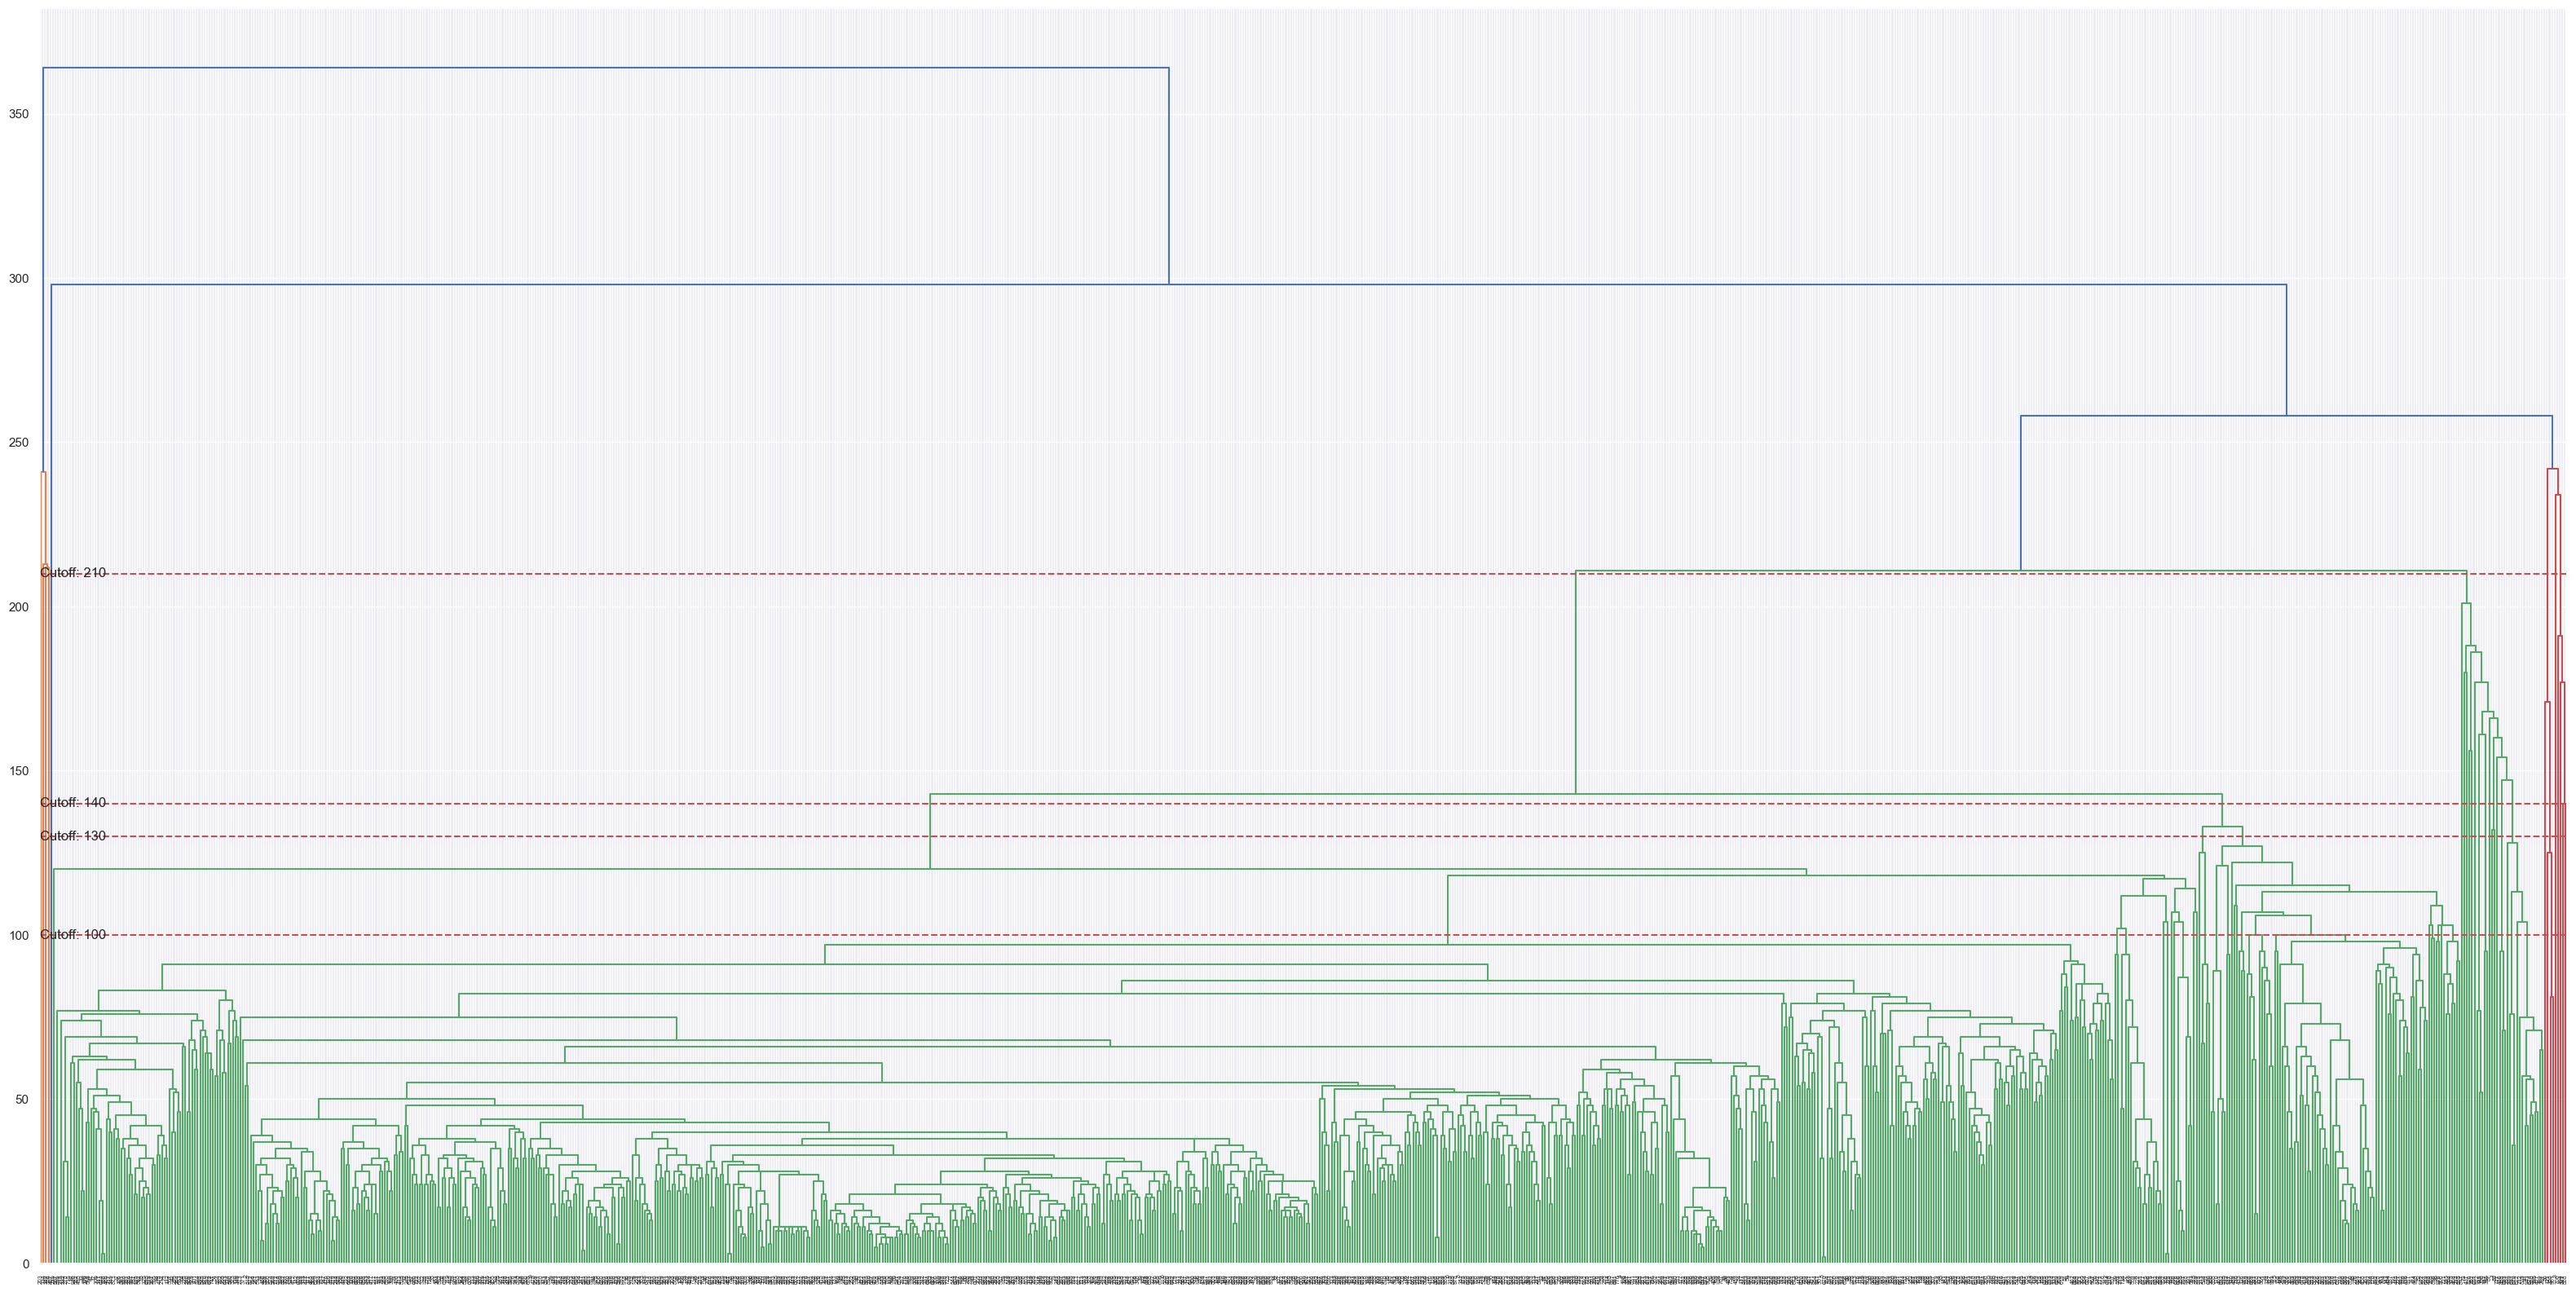

In [15]:
CUTOFF = [100, 130, 140, 210]

# Load the figure object from the previous cell
fig = fig1

# Get the axes object from the figure
ax = fig.axes[0]

# Add the cutoff horizontal line
for cutoff in CUTOFF:
    ax.axhline(y=cutoff, color="r", linestyle="--")
    ax.text(x=ax.get_xlim()[0], y=cutoff, s=f"Cutoff: {cutoff}", va="center")


# Show the plot
fig

In [16]:
# Determine the optimal number of clusters
max_d = 100  # set the threshold distance
clusters = fcluster(Z, max_d, criterion="distance")

In [17]:
# Add cluster labels to the original dataset
urls_tsdf["cluster"] = clusters

#### Evaluation of cluster quality based on cutoff

In [18]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score
silhouette_avg = silhouette_score(
    distances_squareform, urls_tsdf["cluster"], metric="precomputed"
)
print(f"Silhouette score: {silhouette_avg}")

# calculate prevalence of malicious domains in each cluster
cluster_prevalence = urls_tsdf.groupby("cluster")["malicious"].mean()

# group by cluster id and count the number of items in each cluster
cluster_counts = urls_tsdf.groupby("cluster").count()["url"]

# create a dataframe combining the cluster counts and cluster prevalence
cluster_data = pd.DataFrame({"count": cluster_counts, "prevalence": cluster_prevalence})

# filter perfect clusters
non_trivial_clusters = cluster_data.loc[
    (cluster_data["prevalence"] != 0) & (cluster_data["prevalence"] != 1)
]

print(f"Total count of samples {len(urls_tsdf)}")
print(f"Total count of clusters {len(cluster_data)}")
print(
    f"Count of samples in perfect clusters {len(urls_tsdf) - non_trivial_clusters['count'].sum()}"
)

print(
    f"Prevalence of non-perfect malicious domains within clusters:\n{non_trivial_clusters}"
)

Silhouette score: 0.3575962542969081
Total count of samples 1000
Total count of clusters 56
Count of samples in perfect clusters 107
Prevalence of non-perfect malicious domains within clusters:
         count  prevalence
cluster                   
5          815    0.292025
7           17    0.823529
24          61    0.704918


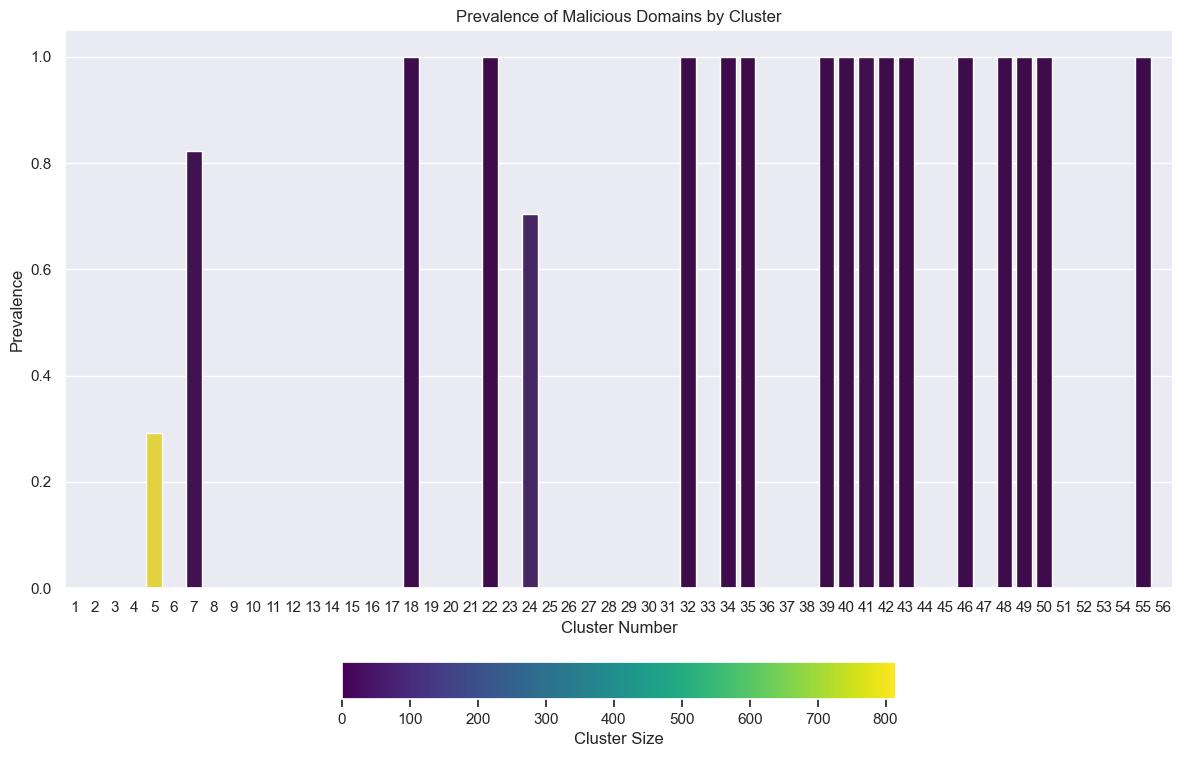

In [19]:
# reset the index to get the cluster id as a column
cluster_data = cluster_data.reset_index()

# Create color palette
colors = sns.color_palette("viridis", as_cmap=True)

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(
    x="cluster",
    y="prevalence",
    data=cluster_data,
    palette=colors(cluster_data["count"] / cluster_data["count"].max()),
    ax=ax,
    dodge=False,
)

# Set labels and title
ax.set_title("Prevalence of Malicious Domains by Cluster")
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Prevalence")

# Move the legend outside the plot and make it a gradient line
sm = plt.cm.ScalarMappable(
    cmap=colors, norm=plt.Normalize(vmin=0, vmax=cluster_data["count"].max())
)
sm.set_array([])
cbar = plt.colorbar(
    sm,
    orientation="horizontal",
    pad=0.1,
    shrink=0.5,
    aspect=15,
)
cbar.ax.set_xlabel("Cluster Size")

plt.subplots_adjust(right=0.8)

plt.tight_layout()

plt.show()

In [20]:
urls_tsdf.groupby("cluster").count()

,url,type,domain,has_www,benign,defacement,malware,phishing,malicious
cluster,,,,,,,,,
1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1
5,815,815,815,815,815,815,815,815,815
6,2,2,2,2,2,2,2,2,2
7,17,17,17,17,17,17,17,17,17
8,2,2,2,2,2,2,2,2,2
9,1,1,1,1,1,1,1,1,1
